# Epipolar geometry

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import open3d
from scipy.spatial.transform import Rotation

from kkvis.lib.epipolar import decomp_essential_mat, longuet_higgins
from kkvis.lib.vision import form_transf, make_intrinsics
from kkvis.lib.epipolar import to_homogeneous
from kkvis.datasets.simulated import CVSimulation, Simulated3DDataset, Camera

/Users/kenton/venvs/science/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


This notebook uses simulated data to look at the forward problem and backward problem.

In [2]:
data = Simulated3DDataset(20)
data.points *= 2

In [3]:
# Define camera intrinsics
width = 1080
height = 720
fx = width // 2

K0 = make_intrinsics(fx, fx, width // 2, height // 2)
# K1 = make_intrinsics(fx * 1.5, fx * 1.5, width // 2, height // 2)

# Define camera extrinsics
t = np.array([2, 0, 5], dtype=np.float32)

# Rotations are about the axes, according to the RHR, but passive so the other way
cam_0 = Camera(
K0, 
Rotation.from_euler("xyz", [90,0,0], degrees=True).as_matrix(), t, 
width, 
height
)

cam_1 = Camera(
K0,
Rotation.from_euler("xyz", [90, 0, 0], degrees=True).as_matrix(),
np.array([-2, 0, 5], dtype=np.float32),
width,
height,
)

This shows the locations in image coordinates where the points project to.

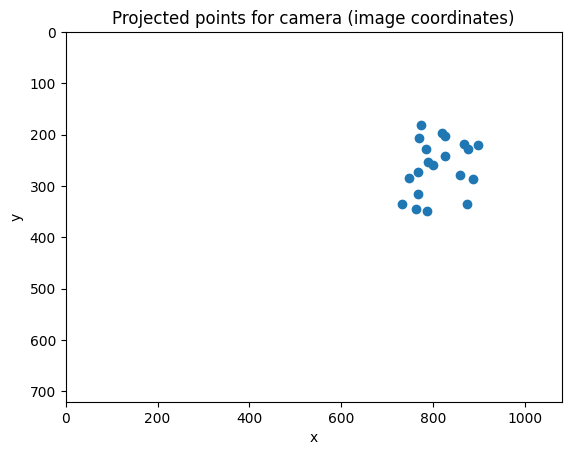

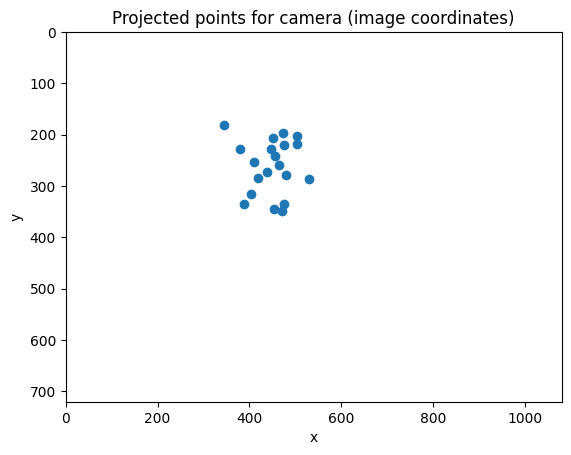

In [4]:
# Make simulation
sim = CVSimulation(data, [cam_0, cam_1])

# Project points
for cam in sim.cameras:
    cam.project_points(sim.data.points, True)

In [5]:
# sim.visualise()

Use OpenCV's methods to estimate the fundamental matrix and essential matrix

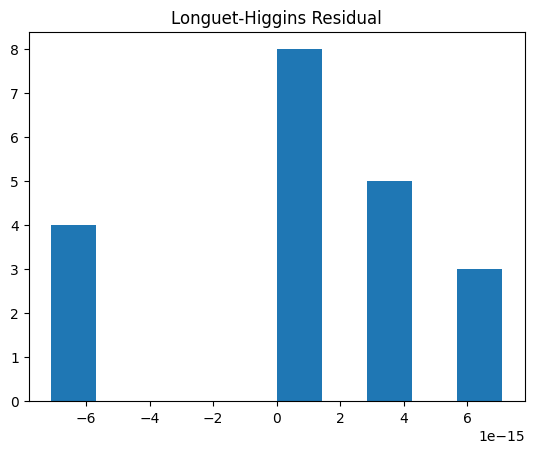

In [6]:
# Calculate fundamental matrix
q0 = cam_0.projected_points
q1 = cam_1.projected_points

# Using the Fundamental matrix method
F, mask = cv2.findFundamentalMat(q0, q1, cv2.FM_LMEDS)

lh_result = longuet_higgins(q0, F, q1)
plt.hist(lh_result)
plt.title('Longuet-Higgins Residual')
plt.show()

In [7]:
print("Calculated fundamental matrix:\n", F)
E_est = K0.T @ F @ K0
E_est /= E_est[2, 2]
print("Estimated essential matrix:\n", E_est)

Calculated fundamental matrix:
 [[-3.10631074e-20  0.00000000e+00  5.40520774e-17]
 [-3.18396851e-19 -2.95099520e-19 -1.24959706e-01]
 [ 8.71786640e-17  1.24959706e-01 -9.23705556e-14]]
Estimated essential matrix:
 [[-1.27480047e+00  0.00000000e+00  2.83306248e+00]
 [-1.30667048e+01 -1.21106044e+01 -9.49671821e+15]
 [-3.36051164e+00  9.49671821e+15  1.00000000e+00]]


In [8]:
# Using the Essential matrix method
E, _ = cv2.findEssentialMat(q0, q1, K0, threshold=1)
E /= E[2, 2]
print("Calculated essential matrix:\n", E)
K_inv = np.linalg.inv(K0)
F_est = K_inv.T @ E @ K_inv
F_est /= F_est[2, 2]
print("Estimated fundamental matrix:\n", F_est)

Calculated essential matrix:
 [[ 1.18337626e+01  8.46351967e+00  4.28079863e-01]
 [-8.18577051e+00  1.18652463e+01  3.96332736e+12]
 [-4.93947417e-01 -3.96332736e+12  1.00000000e+00]]
Estimated fundamental matrix:
 [[ 2.94005083e-06  2.10272750e-06 -2.28717780e-03]
 [-2.03372184e-06  2.94787284e-06  5.31723301e+08]
 [-9.21755985e-04 -5.31723301e+08  1.00000000e+00]]


OpenCV's method requires further processing, there are 4 solutions

In [9]:
# Decompose essential matrix
R1, R2, t = cv2.decomposeEssentialMat(E_est)
t = np.squeeze(t)
print(R1, R2)
print(t)

[[ 1.00000000e+00  5.55401508e-17 -1.37591792e-15]
 [ 1.03957881e-15  1.00000000e+00 -1.27524100e-15]
 [ 1.37591792e-15 -1.05299534e-16  1.00000000e+00]] [[ 1.00000000e+00  6.52180468e-16 -1.37591792e-15]
 [ 1.74729943e-15 -1.00000000e+00  1.27524100e-15]
 [-1.37591792e-15  1.05299534e-16 -1.00000000e+00]]
[-1.00000000e+00 -1.39343912e-15 -2.47524511e-30]


In [10]:
R_calc, t = decomp_essential_mat(E_est, q0, q1, K0, K0)
T_est = form_transf(R_calc, t)
print("Verify the equality of the rototranslation of camera 1 compared with camera 0")
print(cam_1.pose @ np.linalg.inv(cam_0.pose))
print(T_est)

print("Verify equality of the pose of camera 1")
print(cam_1.pose)
print(T_est @ cam_0.pose)

Verify the equality of the rototranslation of camera 1 compared with camera 0
[[ 1.  0.  0. -4.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
[[ 1.00000000e+00  5.55401508e-17 -1.37591792e-15 -1.00000000e+00]
 [ 1.03957881e-15  1.00000000e+00 -1.27524100e-15 -1.39343912e-15]
 [ 1.37591792e-15 -1.05299534e-16  1.00000000e+00 -2.47524511e-30]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Verify equality of the pose of camera 1
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -2.00000000e+00]
 [ 0.00000000e+00  2.22044605e-16 -1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  2.22044605e-16  5.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.00000000e+00 -1.37591792e-15 -5.55401508e-17  1.00000000e+00]
 [ 1.03957881e-15 -1.05319640e-15 -1.00000000e+00 -5.69048651e-15]
 [ 1.37591792e-15  1.00000000e+00  3.27344139e-16  5.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]

Triangulate points back into 3D space by backprojection of points. 

In [11]:
# Construct projection matrices
P_ref = np.concatenate((cam_0.K, np.zeros((3, 1))), axis=1)
P_test = np.matmul(np.concatenate((cam_1.K, np.zeros((3, 1))), axis=1), T_est)
# 
hom_Q1 = cv2.triangulatePoints(P_ref, P_test, q0.T, q1.T)

print('Triangulated homogeneous coordinates')
# Equivalent to cv2.convertPointsFromHomogeneous(hom_Q1.T)
estimated_xc = (hom_Q1[0:3] / hom_Q1[3, :]).T
print(estimated_xc)

Triangulated homogeneous coordinates
[[ 0.77440675 -0.30138169  1.60759468]
 [ 0.77244159 -0.32294706  1.4618274 ]
 [ 0.71879361 -0.48183138  1.6958865 ]
 [ 0.69172076 -0.26444746  1.64586252]
 [ 0.78402228 -0.03551803  1.71279832]
 [ 0.54356465 -0.41630992  1.2601092 ]
 [ 0.88907838 -0.48930917  1.68500607]
 [ 0.89957928 -0.39026459  1.48073968]
 [ 0.55913721 -0.07167664  1.56996051]
 [ 0.97233446 -0.20733097  1.51092416]
 [ 0.63227781 -0.22807517  1.63711684]
 [ 0.78421697 -0.30881775  1.2593949 ]
 [ 0.80604786 -0.47187404  1.558467  ]
 [ 0.84091015 -0.21851598  1.42975395]
 [ 0.8488156  -0.33338336  1.28011274]
 [ 0.83531893 -0.06446315  1.35519128]
 [ 0.65771418 -0.28509839  1.43185539]
 [ 0.71930076 -0.05102241  1.74418692]
 [ 0.60443838 -0.32655416  1.33065476]
 [ 0.6266458  -0.1222128   1.48315539]]


In [12]:
# Calculate locations of points in camera 0's coordinates
print('Actual Locations')
actual_xc = np.einsum('ij,kj->ki', cam_0.pose[:3], to_homogeneous(data.points))
print(actual_xc)

Actual Locations
[[ 3.09762701 -1.20552675  6.43037873]
 [ 3.08976637 -1.29178823  5.8473096 ]
 [ 2.87517442 -1.92732552  6.783546  ]
 [ 2.76688304 -1.05778984  6.58345008]
 [ 3.13608912 -0.14207212  6.85119328]
 [ 2.1742586  -1.66523969  5.04043679]
 [ 3.5563135  -1.95723668  6.7400243 ]
 [ 3.59831713 -1.56105835  5.92295872]
 [ 2.23654885 -0.28670657  6.27984204]
 [ 3.88933783 -0.82932388  6.04369664]
 [ 2.52911122 -0.91230066  6.54846738]
 [ 3.1368679  -1.23527099  5.0375796 ]
 [ 3.22419145 -1.88749616  6.23386799]
 [ 3.3636406  -0.87406391  5.7190158 ]
 [ 3.39526239 -1.33353343  5.12045094]
 [ 3.34127574 -0.2578526   5.42076512]
 [ 2.6308567  -1.14039354  5.72742154]
 [ 2.87720303 -0.20408962  6.97674768]
 [ 2.41775351 -1.30621665  5.32261904]
 [ 2.50658321 -0.48885118  5.93262155]]


The actual coordinates will only be known up to a scale.

In [13]:
actual_xc / estimated_xc

array([[4., 4., 4.],
       [4., 4., 4.],
       [4., 4., 4.],
       [4., 4., 4.],
       [4., 4., 4.],
       [4., 4., 4.],
       [4., 4., 4.],
       [4., 4., 4.],
       [4., 4., 4.],
       [4., 4., 4.],
       [4., 4., 4.],
       [4., 4., 4.],
       [4., 4., 4.],
       [4., 4., 4.],
       [4., 4., 4.],
       [4., 4., 4.],
       [4., 4., 4.],
       [4., 4., 4.],
       [4., 4., 4.],
       [4., 4., 4.]])